In [1]:
import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from matplotlib import pyplot as plt
import inspect, random, os
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import Chem
from multiprocessing import Pool
from rdkit.Chem import Draw, PandasTools
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from torch_geometric.nn.aggr import AttentionalAggregation
import torch
from modules.som_dataset import CustomDataset
# from models.som_models import GNNSOM
from modules.som_models import GNNSOM
from utils import validation
from tabulate import tabulate
from tqdm import tqdm
import numpy as np
from scipy import stats
from collections import defaultdict
from glob import glob
import json
import warnings
warnings.filterwarnings('ignore', '.*Sparse CSR tensor support is in beta state.*')
warnings.filterwarnings('ignore', '')

In [14]:
def CYP_REACTION(x):
    cyp_col = ['BOM_1A2', 'BOM_2A6', 'BOM_2B6', 'BOM_2C8', 'BOM_2C9', 'BOM_2C19', 'BOM_2D6', 'BOM_2E1', 'BOM_3A4']
    cyp_reactions = x[cyp_col].tolist()
    cyp_reactions = [i for i in cyp_reactions if i] 
    return '\n'.join( cyp_reactions )

In [15]:
cyp_list = [f'BOM_{i}' for i in  '1A2 2A6 2B6 2C8 2C9 2C19 2D6 2E1 3A4'.split()] + ['CYP_REACTION']

In [16]:
class CONFIG:
    substrate_loss_weight = 0.33    
    bond_loss_weight = 0.33
    atom_loss_weight = 0.33
    som_type_loss_weight = 0.33
    class_type = 2    
    th = 0.1    
    substrate_th = 0.5
    adjust_substrate = False
    average = 'binary'    
    equivalent_bonds_mean = True
    train_only_spn_H_atom = False    
    device = 'cuda:0'
    test_only_reaction_mol = False
    drop_node_p = 0.0
    mask_node_p = 0.0
    filt_som = 0
    equivalent_mean = False
    reduction = 'sum'
    metric_mode = 'bond'
    n_classes = 5
args = CONFIG()



In [17]:
model = GNNSOM(
            num_layers=2,
            gnn_num_layers = 8,
            pooling='sum',
            dropout=0.1, 
            cyp_list=cyp_list, 
            use_face = True, 
            node_attn = True,
            face_attn = True,            
            n_classes=args.n_classes,
            ).to('cuda:0')

In [18]:
test_df = PandasTools.LoadSDF('data/test_0628.sdf')
test_df['CYP_REACTION'] = test_df.apply(CYP_REACTION, axis=1)
test_df['POS_ID'] = 'TEST' + test_df.index.astype(str).str.zfill(4)

test_dataset = CustomDataset(df=test_df, cyp_list=cyp_list, args=args)
test_loader = DataLoader(test_dataset, num_workers=2, batch_size=8, shuffle=False)

loss_fn_ce, loss_fn_bce = torch.nn.CrossEntropyLoss(), torch.nn.BCEWithLogitsLoss()

Processing...
Done!


In [19]:
args.ckpt = ...
model.load_state_dict(torch.load(args.ckpt, 'cpu'))
test_scores = validation(model, test_loader, loss_fn_ce, loss_fn_bce, args)
validator = test_scores['validator'] 

In [24]:
print(validator.y_prob.keys())
print(validator.y_prob['bond_som'].keys())

dict_keys(['subs', 'bond_som', 'atom_som', 'atom_spn', 'dea', 'epo', 'oxi', 'dha', 'dhy', 'rdc'])
dict_keys(['BOM_1A2', 'BOM_2A6', 'BOM_2B6', 'BOM_2C8', 'BOM_2C9', 'BOM_2C19', 'BOM_2D6', 'BOM_2E1', 'BOM_3A4', 'CYP_REACTION'])


In [27]:
y_bond_som_1A2 = np.array(validator.y_prob['bond_som']['BOM_1A2'])

(array([  14.,   37.,   22.,   16.,   26.,  267., 1947., 3078.,  838.,
          93.]),
 array([0.47150618, 0.48197706, 0.49244795, 0.50291883, 0.51338972,
        0.5238606 , 0.53433149, 0.54480237, 0.55527326, 0.56574414,
        0.57621503]),
 <BarContainer object of 10 artists>)

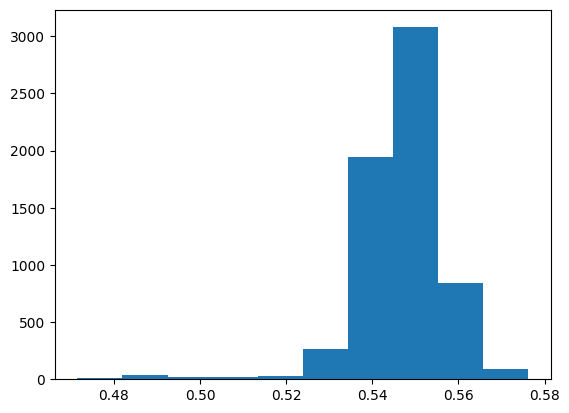

In [29]:
plt.hist(y_bond_som_1A2)